# Networks: structure, evolution & processes
**Internet Analytics - Lab 2**

---

**Group:** K

**Names:**

*  Xavier Jeanmonod
*  Adrian Baudat
*  Simon Wicky

---

#### Instructions

*This is a template for part 4 of the lab. Clearly write your answers, comments and interpretations in Markodown cells. Don't forget that you can add $\LaTeX$ equations in these cells. Feel free to add or remove any cell.*

*Please properly comment your code. Code readability will be considered for grading. To avoid long cells of codes in the notebook, you can also embed long python functions and classes in a separate module. Don’t forget to hand in your module if that is the case. In multiple exercises, you are required to come up with your own method to solve various problems. Be creative and clearly motivate and explain your methods. Creativity and clarity will be considered for grading.*

---

## 2.4 PageRank

### 2.4.1 Random Surfer Model

#### Exercise 2.12

In [1]:
import networkx as nx
import matplotlib.pyplot as plt

with open("../data/absorbing.graph", "rb") as f:
    absorbing = nx.read_adjlist(f, create_using=nx.DiGraph())
    
with open("../data/components.graph", "rb") as f:
    components = nx.read_adjlist(f, create_using=nx.DiGraph())
    
with open("../data/wikipedia.graph", "rb") as f:
    wikipedia = nx.read_adjlist(f, create_using=nx.DiGraph())

First let's visualize the two graphs:

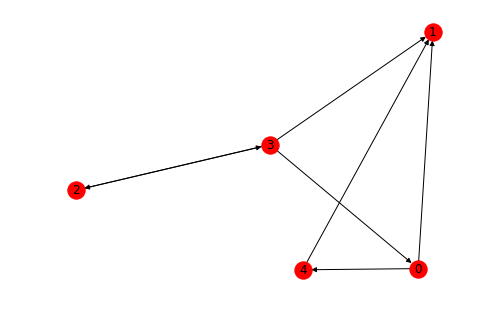

In [9]:
nx.draw(absorbing, arrows = True, with_labels = True)

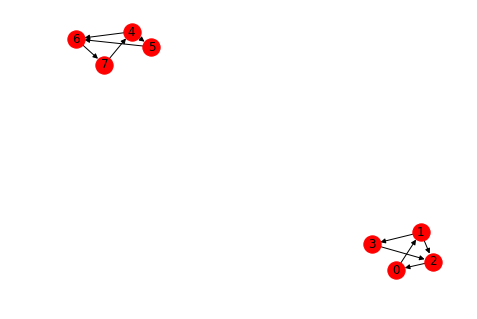

In [10]:
nx.draw(components, arrows = True, with_labels = True)

In [2]:
import random

def random_surf(graph, iterations):
    nx.set_node_attributes(graph, 0, name="rank")
    nodes = graph.nodes
    current_node = random.choice(list(nodes))
    for i in range(iterations):
        graph.node[current_node]['rank'] += 1
        out_edges = graph.out_edges(current_node)
        if len(out_edges) == 0:
            print("Terminated early because node has no outgoing edge")
            return
        else:
            current_node = random.choice(list(out_edges))[1]

def rank_colors(graph):
    node_color = []
    max_rank = 0
    for node in graph.nodes(data=True):
        if node[1]['rank'] > max_rank:
            max_rank = node[1]['rank']
            
    for node in graph.nodes(data=True):
        node_rank = node[1]['rank']
        if node_rank == 0:
            node_color.append([0.2,0.2,0.2])
        else:
            color = 0.8*(node_rank/max_rank)
            node_color.append([color,color,color])
    return node_color

Now let's run the random surf algorithm on the two graphs. The brighter the node, the higher the rank.

Terminated early because node has no outgoing edge


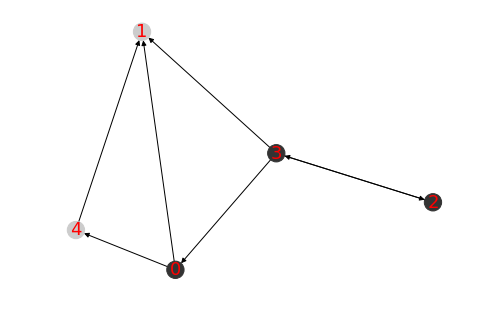

In [22]:
random_surf(absorbing, 1000)
colors = rank_colors(absorbing)
nx.draw(absorbing, arrows = True, with_labels = True, node_color = colors, font_color='r', font_size = 18)

As we can see, on the absorbing graph the algorithm gets stuck in node 1 as it has many edges pointing to it and no edge going out of it.

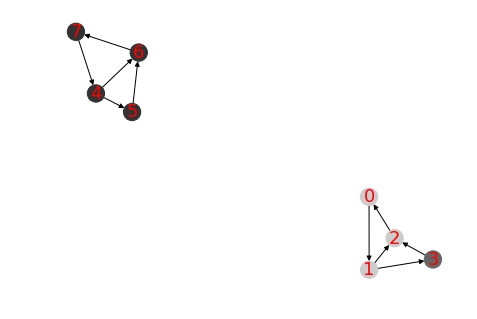

In [23]:
random_surf(components, 1000)
colors = rank_colors(components)
nx.draw(components, arrows = True, with_labels = True, node_color = colors, font_color='r', font_size = 18)

On the components graph, another problem happens: Since the graph is split in two different components, only one of the components is visited. However, as the component has no dead end the algorithm doesn't stop, and yields high ranks for the nodes of the component that is visited and zero ranks for the nodes of the other component

#### Exercise 2.13

In [3]:
def pagerank_surf(graph, iterations, damping_factor = 0.15):
    nx.set_node_attributes(graph, 0, name="rank")
    nodes = graph.nodes
    current_node = random.choice(list(nodes))
    for i in range(iterations):
        graph.node[current_node]['rank'] += 1
        out_edges = graph.out_edges(current_node)
        if len(out_edges) == 0:
            current_node = random.choice(list(nodes))
        else:
            if random.uniform(0, 1) < damping_factor:
                current_node = random.choice(list(nodes))
            else:
                current_node = random.choice(list(out_edges))[1]

Let's run this version of the algorithm on the two graphs.

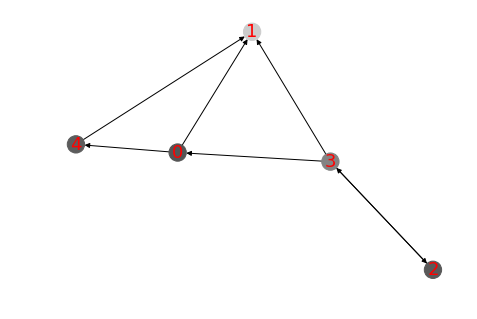

In [24]:
pagerank_surf(absorbing, 1000)
colors = rank_colors(absorbing)
nx.draw(absorbing, arrows = True, with_labels = True, node_color = colors, font_color='r', font_size = 18)

The results we get here do make instinctive sense: The node 1, which is pointed to by 3 nodes is high ranked, while the other nodes, which are pointed to only by 1 node are lower ranked.

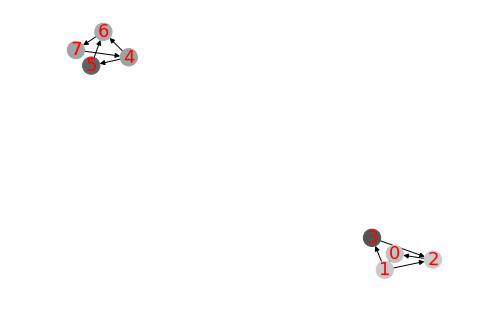

In [25]:
pagerank_surf(components, 1000)
colors = rank_colors(components)
nx.draw(components, arrows = True, with_labels = True, node_color = colors, font_color='r', font_size = 18)

Once again, the results we obtain make sense: Nodes that are the only node being pointed to from a source, and nodes that have multiple nodes pointing to them are highly ranked, while the nodes that are only being pointe to by one node, and that are not the only node their source points to (5 and 3 in this case) have a low rank.

---

### 2.4.2 Power Iteration Method

#### Exercise 2.14: Power Iteration method

In [34]:
import numpy as np
def power_iteration_method(Graph, damping_factor=0.15, iter_max=10000, convergence_at = 0):
    n = len(Graph.nodes())
    Pis = np.ones(n) * np.double((1/n))
    previous_Pis = np.zeros(n)
    random_restart = np.double(1/n) * np.ones((n, n))
    transition_matrix = np.zeros((n, n))
    for u, v in Graph.edges:
        Ou = len(list(Graph.neighbors(u)))
        transition_matrix[int(u), int(v)] = np.double(1/Ou)
    w = [1 if len(list(Graph.neighbors(x)))== 0 else 0 for x in Graph.nodes()]
    transition_matrix += (w * np.transpose(np.identity(n)))/np.double(n)
    
    G = damping_factor * random_restart + (1-damping_factor) * transition_matrix
    iterations = 0
    while iterations < iter_max and np.linalg.norm(Pis - previous_Pis) > convergence_at:
        Pis_copy = Pis.copy()
        Pis = np.dot(Pis, G)
        previous_Pis = Pis_copy
        iterations += 1
    
    print("Last step number : " + str(iterations))
    return Pis

In [35]:
wikipedia = nx.read_adjlist("../data/wikipedia.graph", create_using=nx.DiGraph())
wikipedia_rank = power_iteration_method(wikipedia, convergence_at = 5e-6)
ranks = np.flip(np.argsort(wikipedia_rank))
i = 0
for i in range(10):
    print(ranks[i])

Last step number : 824
5210
5201
2034
1890
2168
1811
5477
2999
2619
1818


In [37]:
def wikipedia_dictionnary():
    dictionnary = {}
    with open("../data/wikipedia_titles.tsv", encoding="utf8") as titles:
        #skipping first line
        next(titles)
        for line in titles:
            (number, page) = line.split('\t')
            page = page[:-1]
            dictionnary[int(number)] = page
        return dictionnary
wiki_pages = wikipedia_dictionnary()

In [38]:
for i in range(10):
    print("- " + wiki_pages[ranks[i]])

- United States
- United Kingdom
- France
- Europe
- Germany
- England
- World War II
- Latin
- India
- English language


---

### 2.4.3 Gaming the system

#### Exercise 2.15

In [39]:
#History of mathematics is node 2463
print(wikipedia_rank[2463])

8.210329431327297e-05


The original page rank score of the page History of Mathematics is 8.21e-05. The strategy we will implement is the following: We will sort all nodes by the biggest contribution if an edge towards the page History of Mathematics were added, then we will add 300 nodes starting from the first node in the list, skipping nodes that already have an edge towards the page History of Mathematics.

In [41]:
liste = []
for node in wikipedia.nodes():
    liste.append((node, wikipedia_rank[int(node)] / (wikipedia.out_degree(node)+1)))
index_list = [i[0] for i in sorted(liste, key=lambda x : -x[1])]

In [42]:
wikipedia_aug = wikipedia.copy()
edge_added = 0
index = 0
while edge_added < 300:
    if (str(index_list[index]), '2463') not in wikipedia_aug.in_edges('2463'):
        wikipedia_aug.add_edge(str(index_list[index]), '2463')
        edge_added += 1
    index += 1

In [44]:
wikipedia_aug_rank = power_iteration_method(wikipedia_aug, convergence_at = 4e-6)
ranks_aug = np.flip(np.argsort(wikipedia_aug_rank))
i = 0
for i in range(10):
    print("- " + wiki_pages[ranks_aug[i]])

Last step number : 15
- United States
- History of mathematics
- United Kingdom
- France
- Europe
- Germany
- England
- World War II
- Latin
- India


In [45]:
print(wikipedia_aug_rank[2463])

0.006726878633568667


We manage to obtain a score of 0.00673, which is almost 82 times higher, and raises History of Mathematics to the page with the second best PageRank score.